In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import classification_report


import numpy as np
import pandas as pd
from collections import Counter
from graphviz import Digraph
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
from sklearn.metrics import classification_report

In [2]:

data_file = pd.read_csv('Grades.csv')
data_file.head()


university sex  age address  motherEducation  fatherEducation motherJob  \
0         PR   F   18       U                4                4   at_home   
1         PR   F   17       U                1                1   at_home   
2         PR   F   15       U                1                1   at_home   
3         PR   F   15       U                4                2    health   
4         PR   F   16       U                3                3     other   

  fatherJob  reason  travelTime  ...  internet  romantic freeTime goOut Dalc  \
0   teacher  course           2  ...        no        no        3     4    1   
1     other  course           1  ...       yes        no        3     3    1   
2     other   other           1  ...       yes        no        3     2    2   
3  services    home           1  ...       yes       yes        2     2    1   
4     other    home           1  ...        no        no        3     2    1   

  Walc absences  EPSGrade  DSGrade  finalGrade  
0    1        6         5        6           6  
1    1        4         5        5           6  
2    3       10         7        8          10  
3    1        2        15       14          15  
4    2        4         6       10          10  

[5 rows x 25 columns]

# PreProcess

In [3]:
# Recovering losing data
data_file.loc[ (data_file['reason'] == 'other') & (
                (data_file['finalGrade'] >= 14) | (data_file['DSGrade'] >= 14) |
                (data_file['EPSGrade'] >= 14) |
                (data_file['studyTime'] >= 3) |
                (data_file['higher'] == 'yes') |
                (data_file['paid'] == 'yes') ), 'reason'] = 'course'

data_file.loc[(data_file['reason'] == 'other') & (data_file['travelTime'] == 1), 'reason'] = 'home'

data_file.loc[
    (data_file['reason'] == 'other') &
    ((data_file['motherEducation'] >= 3) | (data_file['fatherEducation'] >= 3) | (data_file['internet'] == 'yes')),
    'reason'
] = 'reputation'

data_file.drop(['sex', 'university', 'age', 'motherJob', 'fatherJob'], axis=1, inplace=True)


def categorize_grade(grade):
    if grade < 10:
        return 0
    elif grade >= 10 and grade < 14:
        return 1
    elif grade >= 14 and grade < 17:
        return 2
    elif grade >= 17:
        return 3

def categorize_absence(absence):
    if absence < 3:
        return 'A'
    elif (absence >= 3 and absence < 7):
        return 'B'
    elif (absence >= 7 and absence < 15):
        return 'C'
    elif (absence >= 15 and absence < 25):
        return 'D'
    elif (absence >= 25 and absence < 35):
        return 'E'
    elif (absence >= 35 and absence < 45):
        return 'F'
    elif (absence >= 45 and absence < 60):
        return 'G'
    elif (absence >= 60 and absence < 80):
        return 'H'
    elif (absence >= 80):
        return 'I'
    

data_file['EPSGradeEncoded'] = data_file['EPSGrade'].apply(categorize_grade)
data_file.drop('EPSGrade', axis=1, inplace=True)

data_file['DSGradeEncoded'] = data_file['DSGrade'].apply(categorize_grade)
data_file.drop('DSGrade', axis=1, inplace=True)

data_file['AIGradeEncoded'] = data_file['finalGrade'].apply(categorize_grade)
data_file.drop('finalGrade', axis=1, inplace=True)

data_file['absencesEncoded'] = data_file['absences'].apply(categorize_absence)
data_file.drop('absences', axis=1, inplace=True)


label_encoders = {}
for column in data_file.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data_file[column] = le.fit_transform(data_file[column])
    label_encoders[column] = le

# Split Data

In [4]:
y = data_file['AIGradeEncoded']
X = data_file.drop('AIGradeEncoded', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=441)

# Naive Bayes (Gaussian)

Confusion Matrix: 

[[21  2  2  0]
 [ 0 14 17  0]
 [ 0  1 10  3]
 [ 0  0  1  9]]



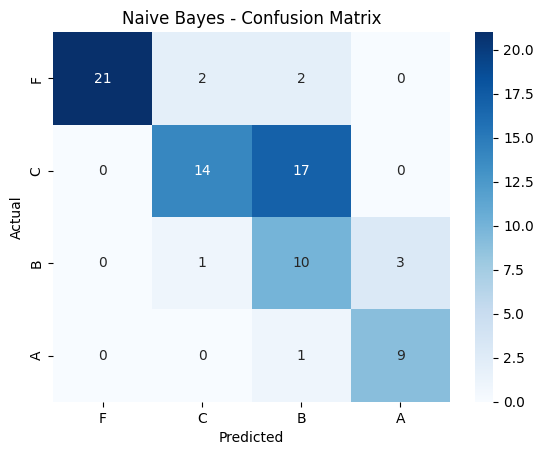

Naive Bayes Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.84      0.91        25
           1       0.82      0.45      0.58        31
           2       0.33      0.71      0.45        14
           3       0.75      0.90      0.82        10

    accuracy                           0.68        80
   macro avg       0.73      0.73      0.69        80
weighted avg       0.78      0.68      0.69        80



In [5]:

nb_gaussian_model = GaussianNB()
nb_gaussian_model.fit(X_train, y_train)
y_pred_nb_gaussian = nb_gaussian_model.predict(X_test)

confusion_matrix(y_test, y_pred_nb_gaussian)
print("Confusion Matrix: \n")
print(confusion_matrix(y_test, y_pred_nb_gaussian), end="\n\n")

cm = confusion_matrix(y_test, y_pred_nb_gaussian)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels = ['F', 'C', 'B', 'A'],
            yticklabels = ['F', 'C', 'B', 'A']
)
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Naive Bayes Classification Report:\n")
print(classification_report(y_test, y_pred_nb_gaussian))

# Naive Bayes (Categorical)

Confusion Matrix: 

[[20  5  0  0]
 [ 1 29  1  0]
 [ 0  2 12  0]
 [ 0  0  6  4]]



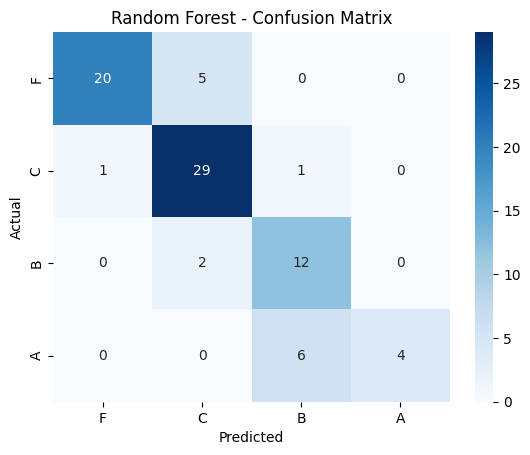

Naive Bayes Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.80      0.87        25
           1       0.81      0.94      0.87        31
           2       0.63      0.86      0.73        14
           3       1.00      0.40      0.57        10

    accuracy                           0.81        80
   macro avg       0.85      0.75      0.76        80
weighted avg       0.85      0.81      0.81        80



In [6]:

nb_categorical_model = CategoricalNB()
nb_categorical_model.fit(X_train, y_train)
y_pred_nb_categorical = nb_categorical_model.predict(X_test)

confusion_matrix(y_test, y_pred_nb_categorical)
print("Confusion Matrix: \n")
print(confusion_matrix(y_test, y_pred_nb_categorical), end="\n\n")

cm = confusion_matrix(y_test, y_pred_nb_categorical)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels = ['F', 'C', 'B', 'A'],
            yticklabels = ['F', 'C', 'B', 'A']
)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Naive Bayes Classification Report:\n")
print(classification_report(y_test, y_pred_nb_categorical))

# Scale Data

In [7]:
split_methods = ['STD' , 'MinMax']
method = split_methods[1]

if method == 'STD':
    scaler = StandardScaler()
elif method == 'MinMax':
    scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Decision Tree Classifier (No limit)

Decision Tree Report:

              precision    recall  f1-score   support

           0       0.86      0.72      0.78        25
           1       0.70      0.84      0.76        31
           2       0.64      0.64      0.64        14
           3       0.88      0.70      0.78        10

    accuracy                           0.75        80
   macro avg       0.77      0.73      0.74        80
weighted avg       0.76      0.75      0.75        80



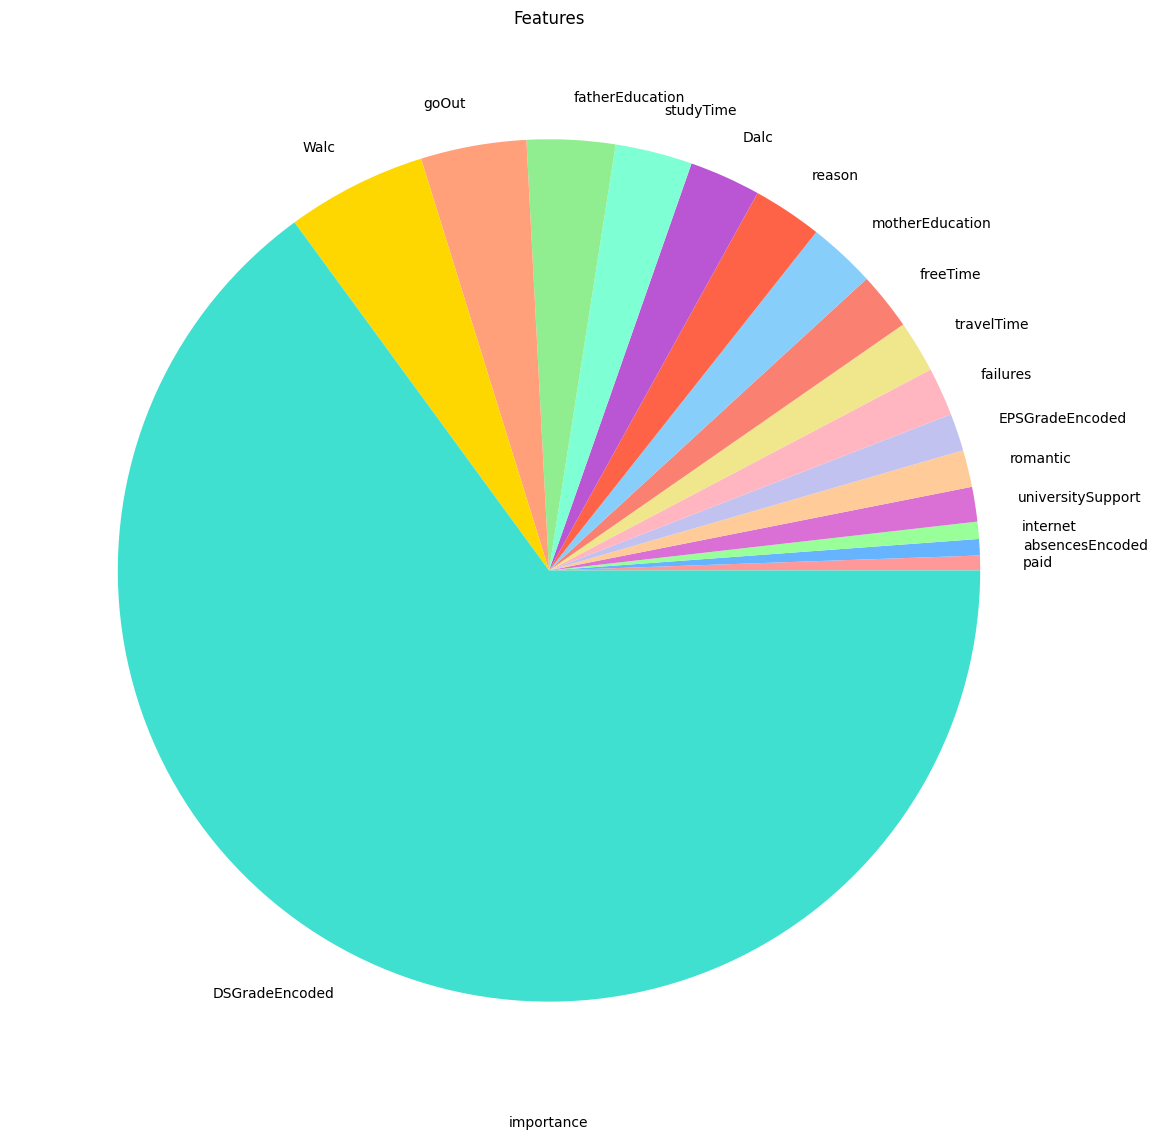

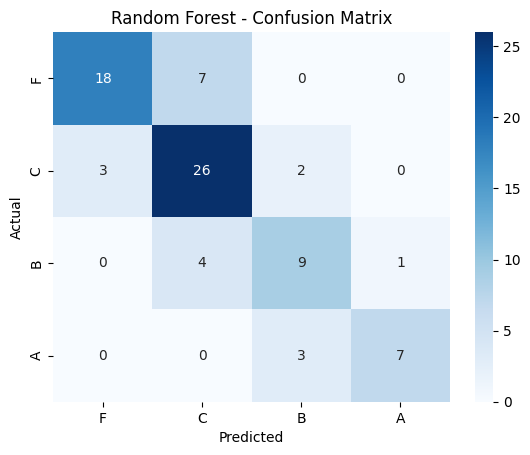

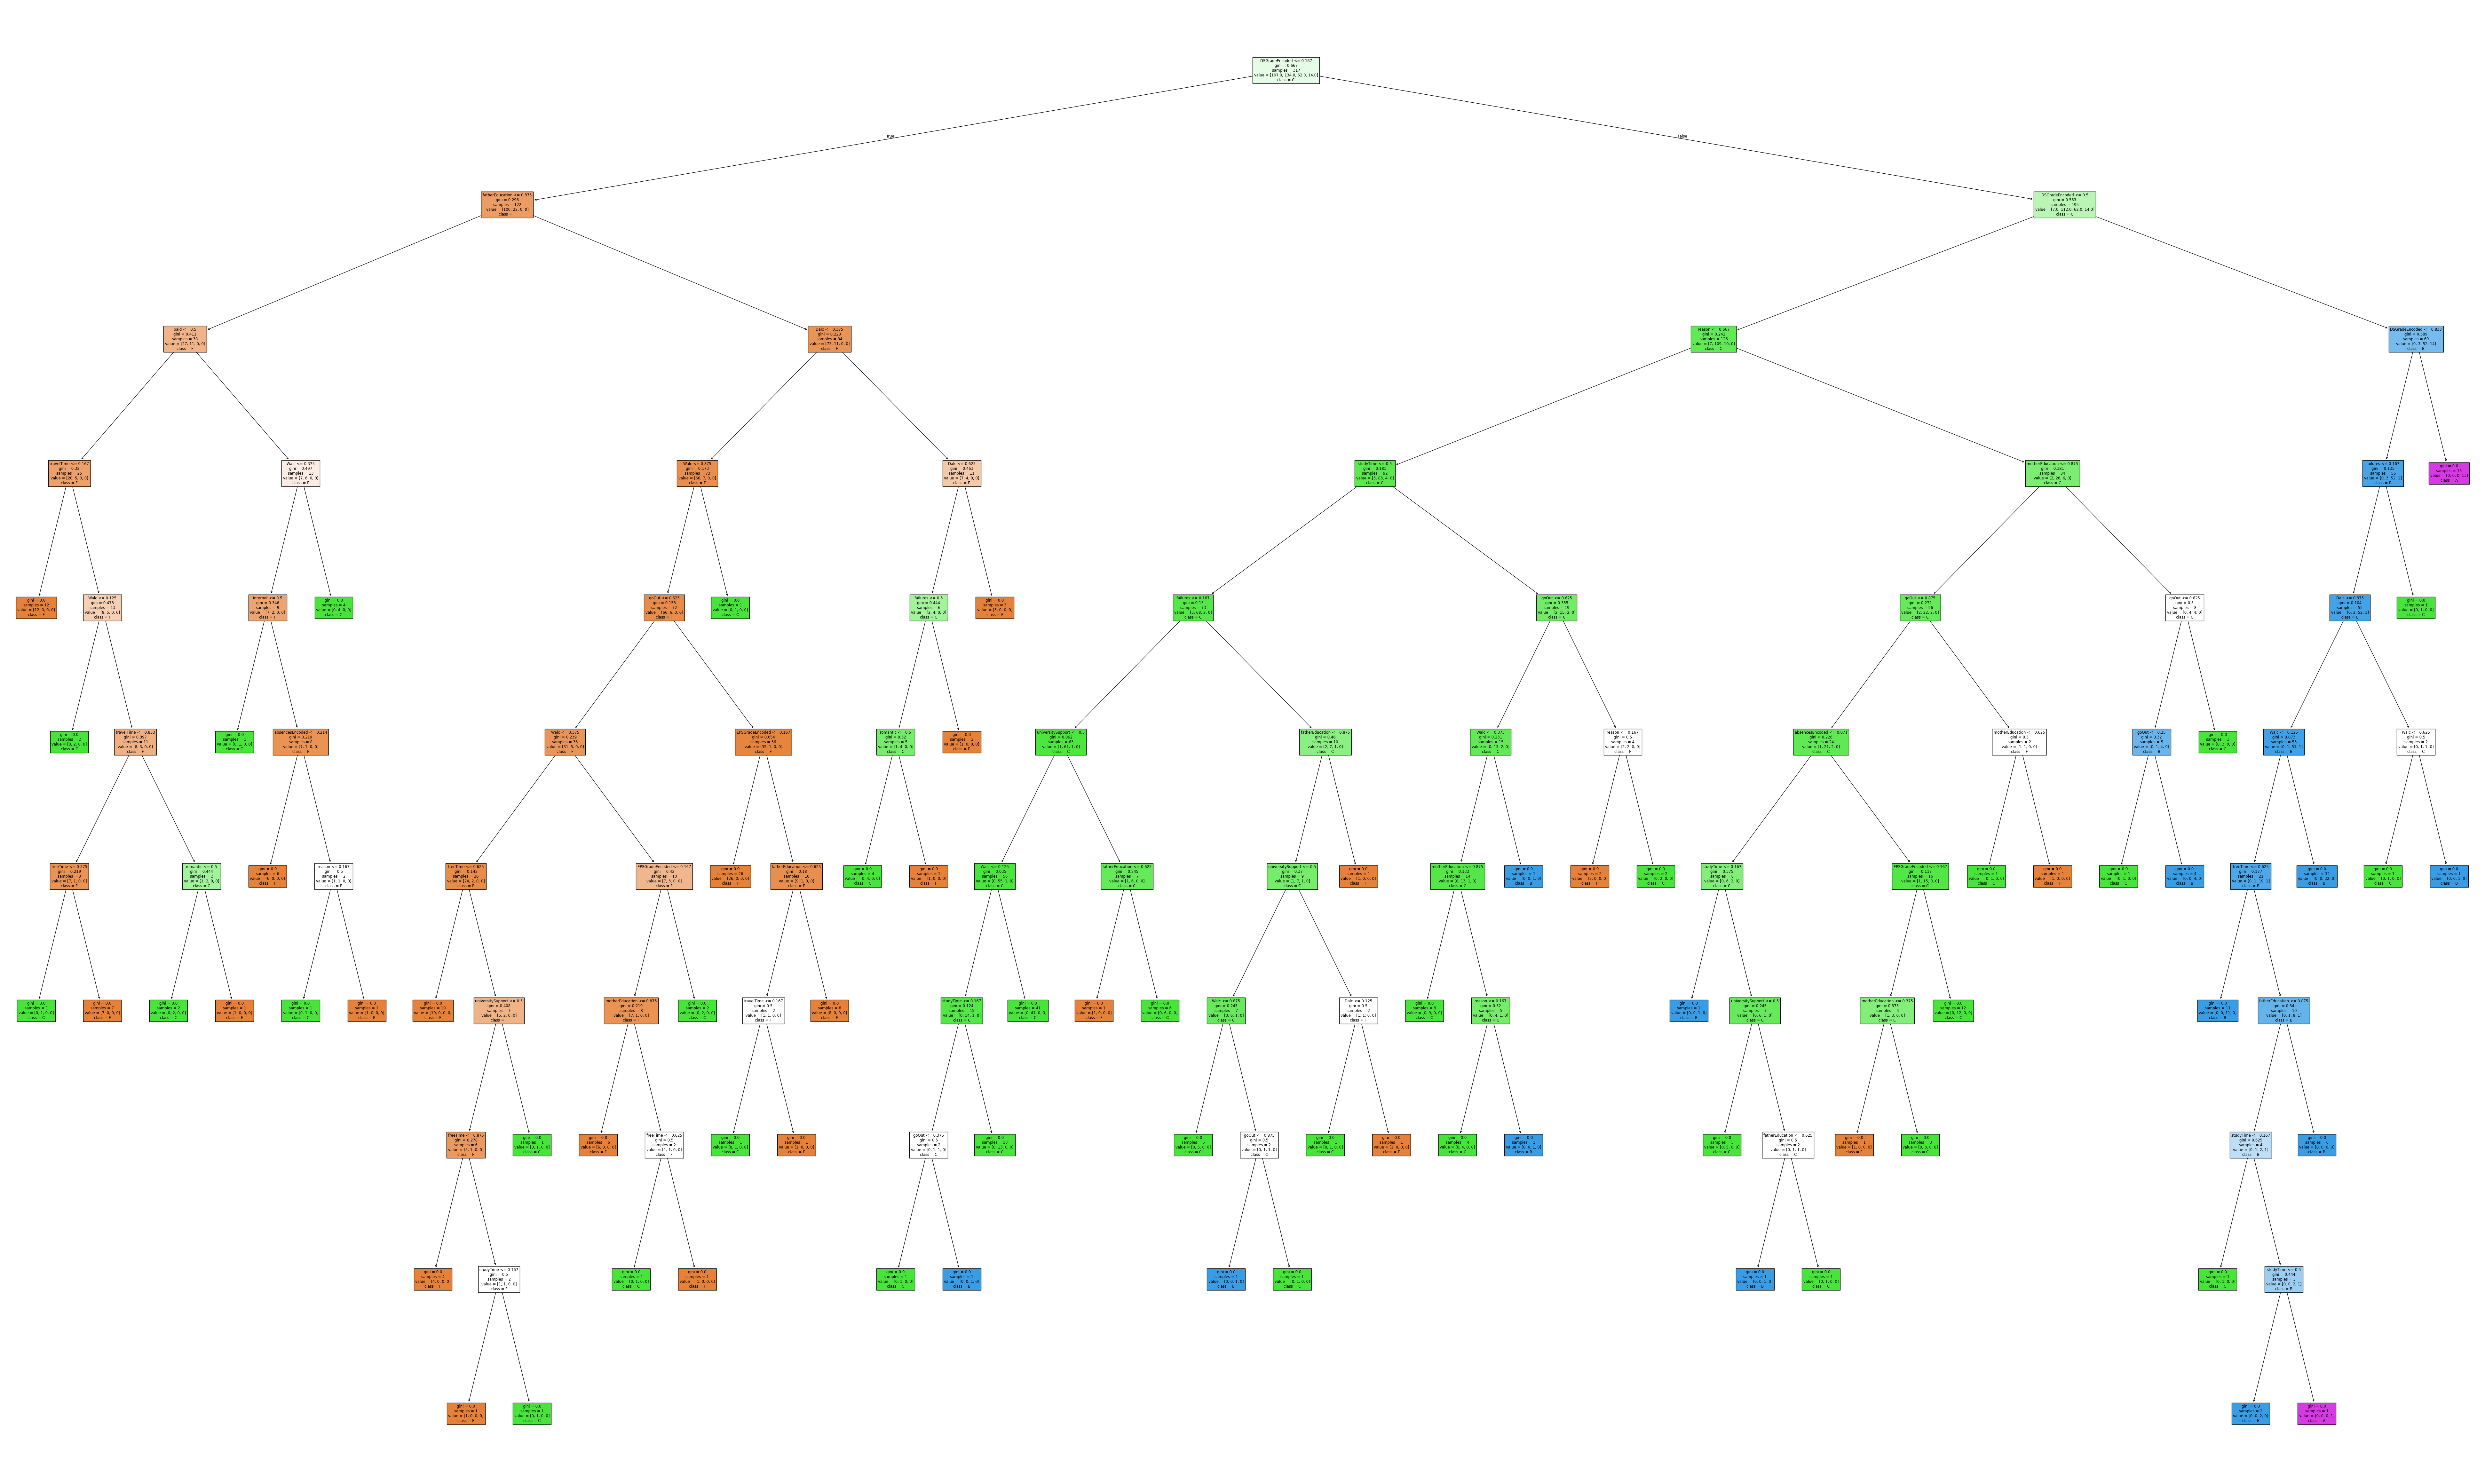

In [8]:
dt_model = DecisionTreeClassifier(random_state=441)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Report:\n")
print(classification_report(y_test, y_pred_dt))


importances = pd.Series(dt_model.feature_importances_ , index= X_train.columns)
importances = importances.sort_values()

colors = ['#FFD700','#40E0D0','#FF9999','#66B3FF','#99FF99','#DA70D6','#FFCC99','#C2C2F0','#FFB6C1','#F0E68C','#FA8072','#87CEFA','#FF6347','#BA55D3','#7FFFD4','#90EE90','#FFA07A']

plt.figure(figsize=(20, 14))
importances.plot(kind='pie',colors=colors)
plt.title("Features")
plt.xlabel("importance")
plt.show()

cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels = ['F', 'C', 'B', 'A'],
            yticklabels = ['F', 'C', 'B', 'A']
)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(100,60))
plot_tree(dt_model, filled=True,
          feature_names=data_file.drop('AIGradeEncoded', axis=1).columns,
          class_names=['F','C','B','A'])
plt.show()



# Decision Tree Classifier

Decision Tree Report:

              precision    recall  f1-score   support

           0       0.86      0.76      0.81        25
           1       0.72      0.84      0.78        31
           2       0.67      0.71      0.69        14
           3       1.00      0.70      0.82        10

    accuracy                           0.78        80
   macro avg       0.81      0.75      0.77        80
weighted avg       0.79      0.78      0.78        80



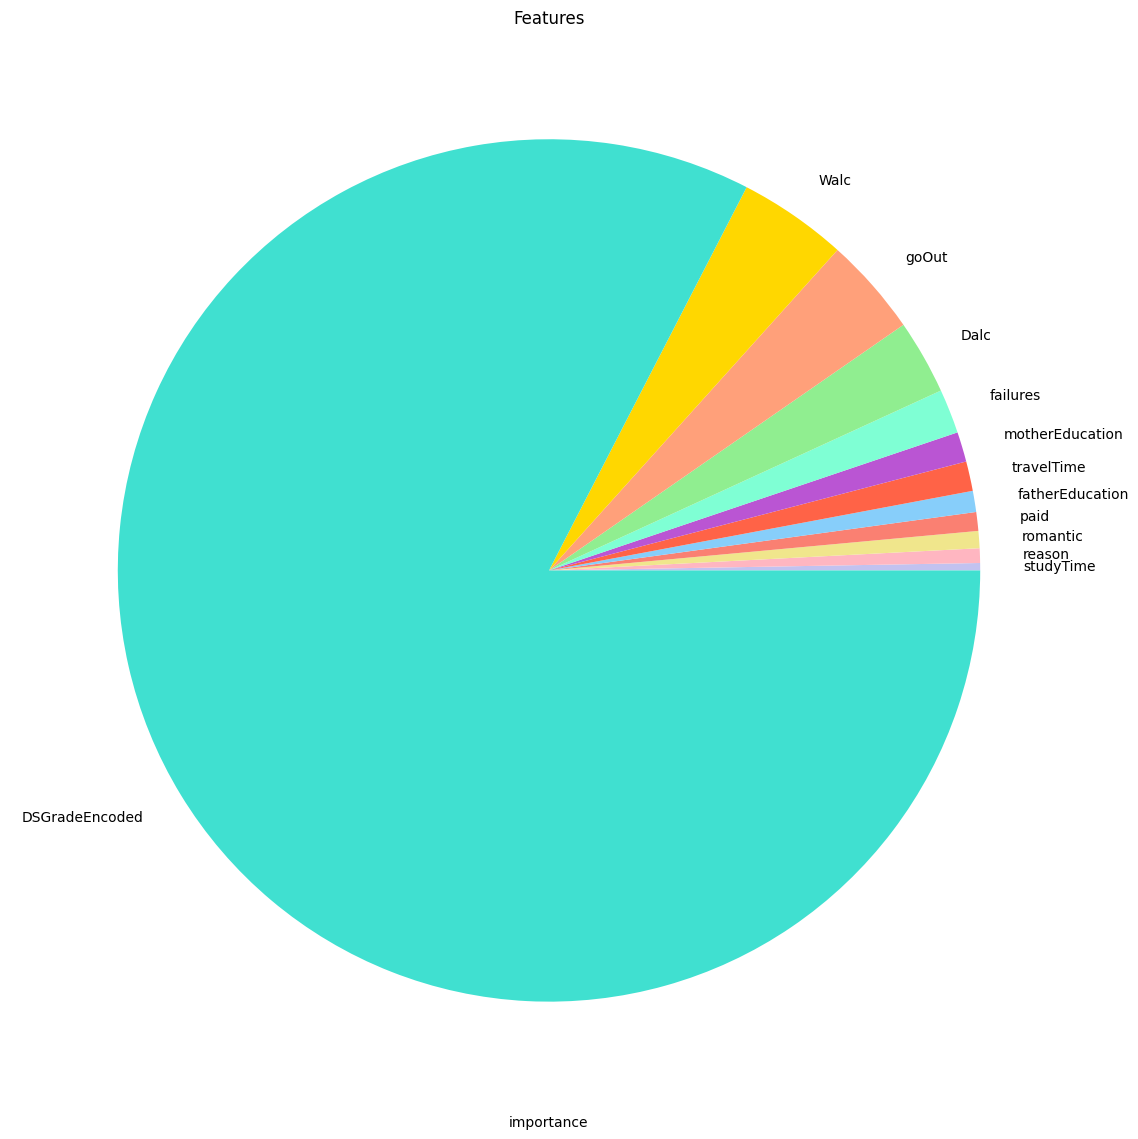

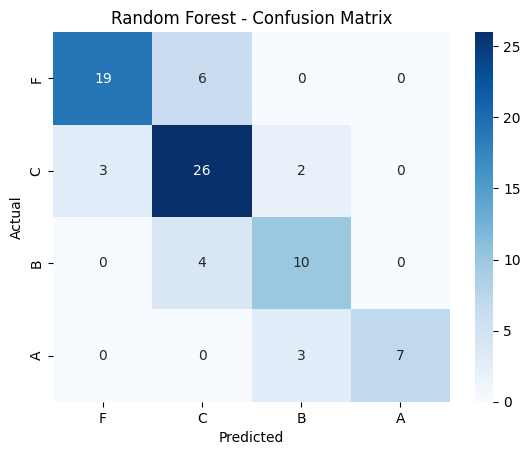

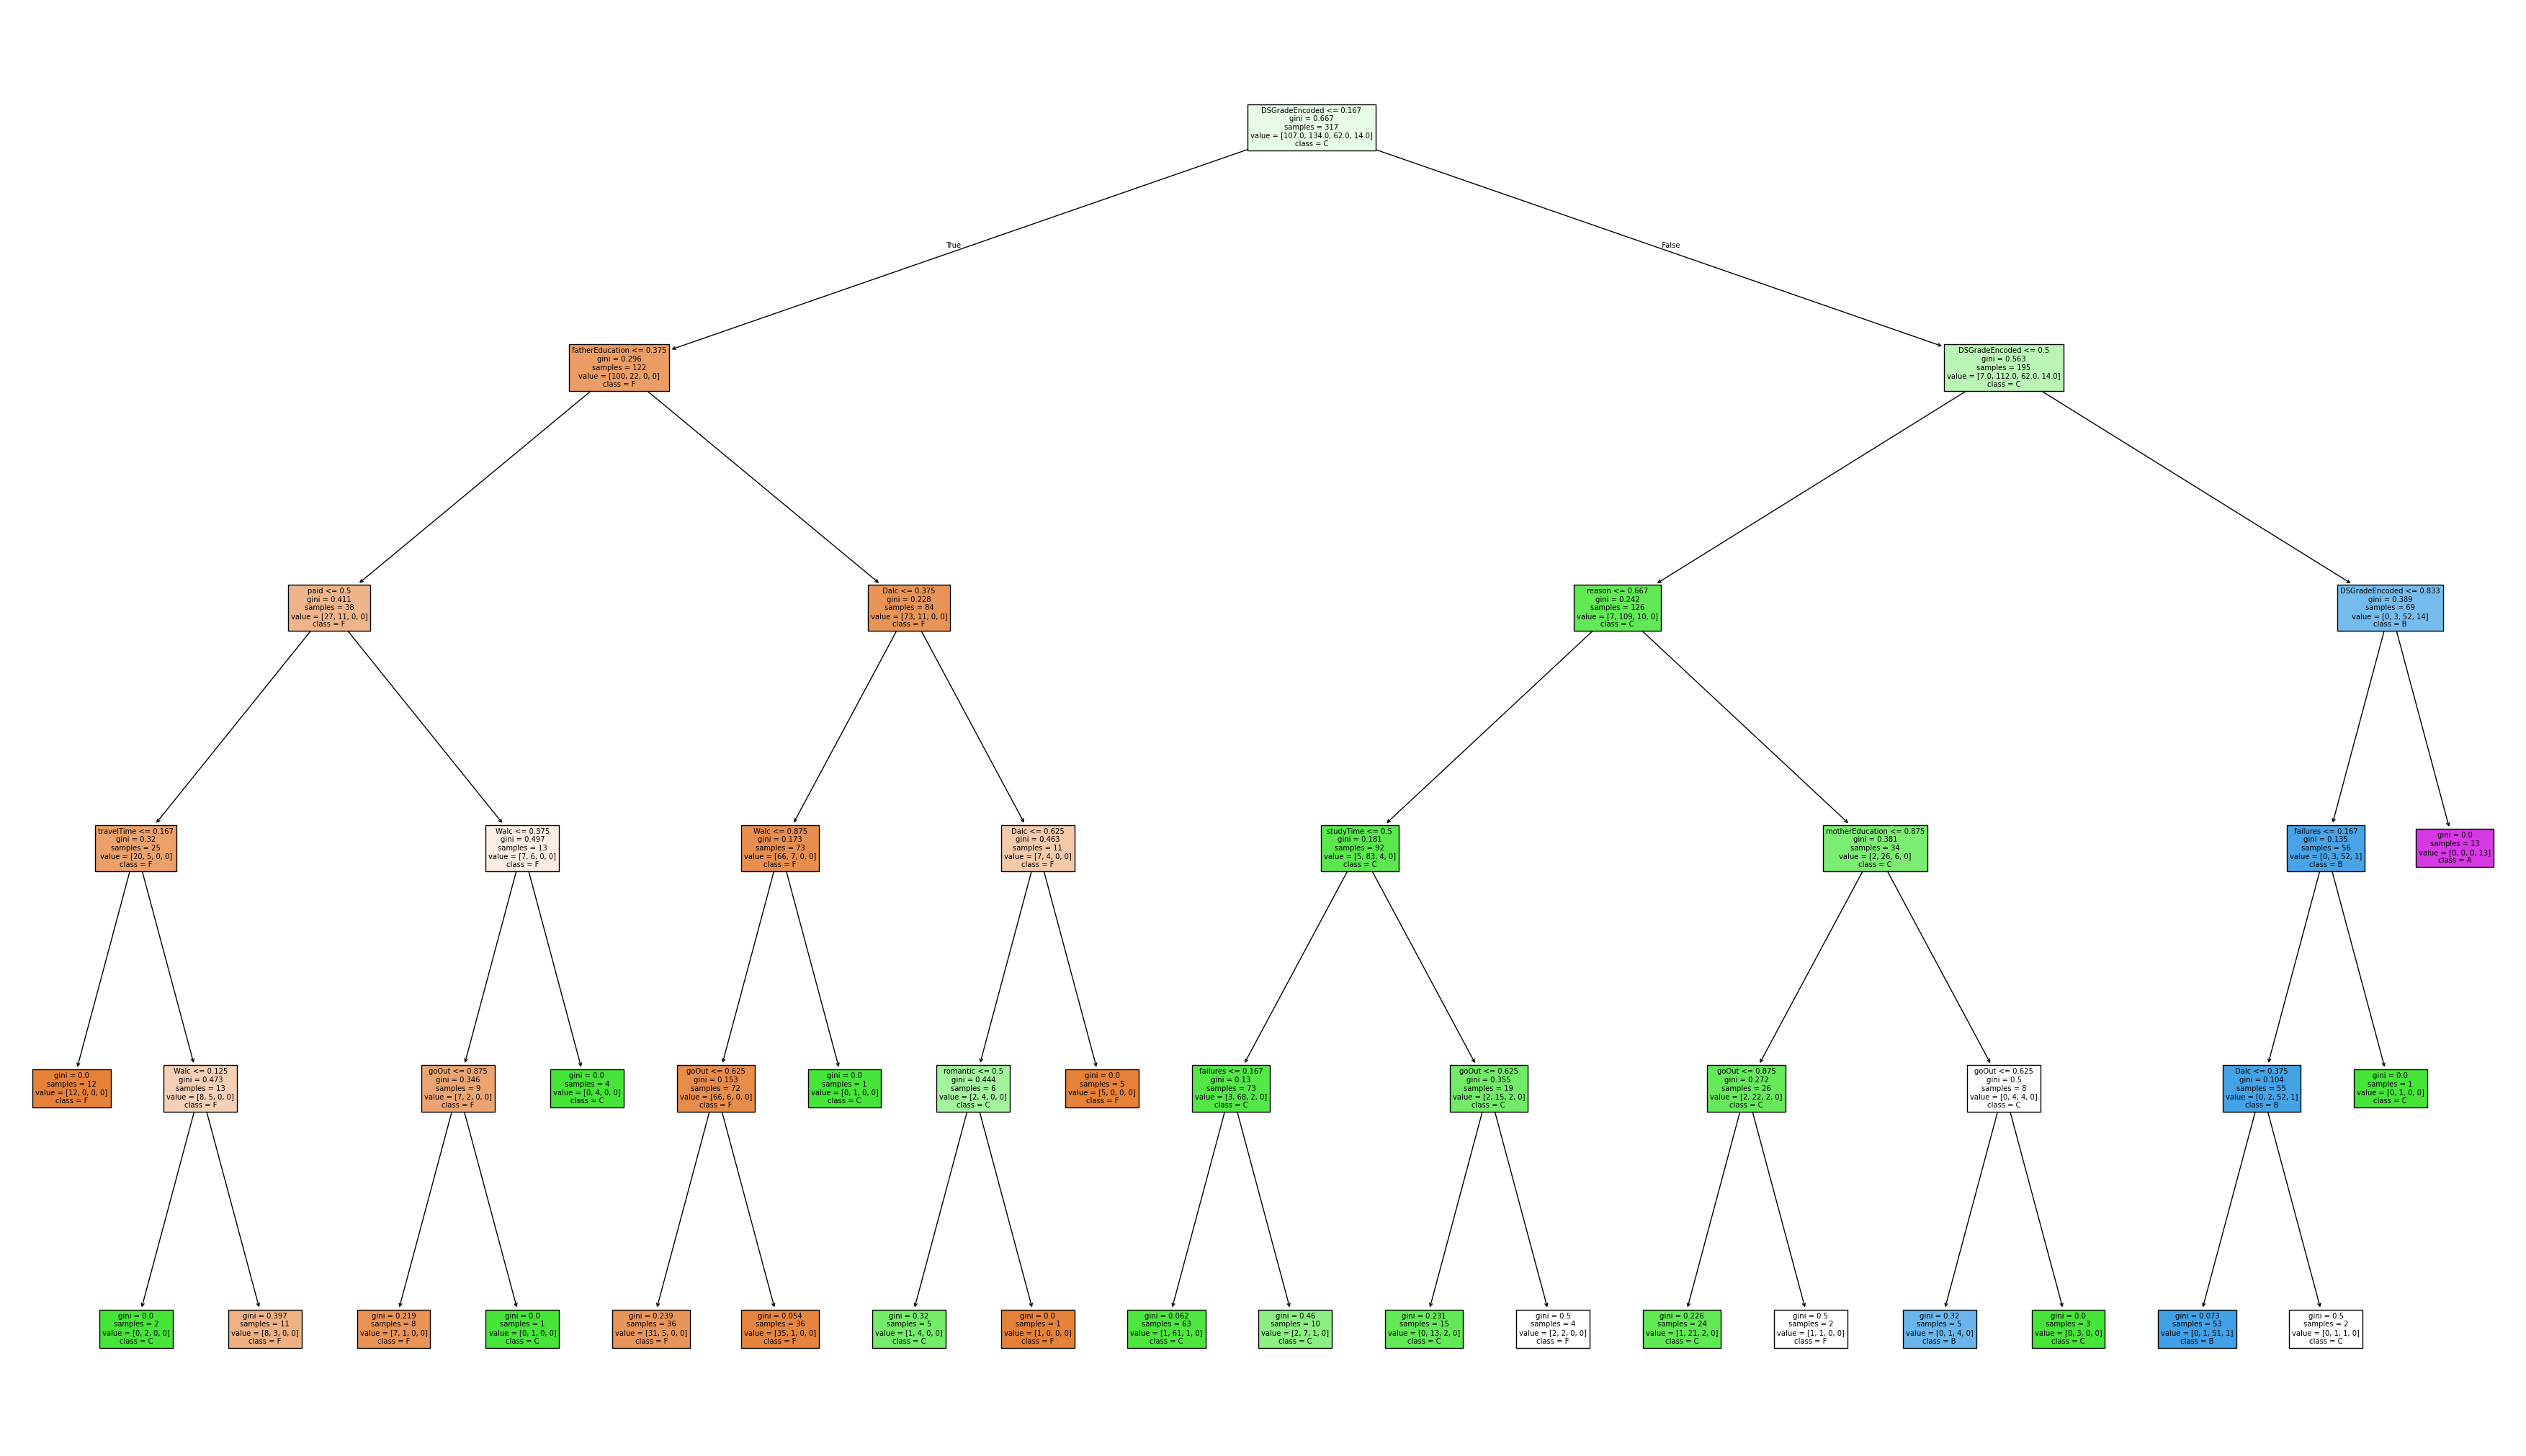

In [9]:
dt_limit_model = DecisionTreeClassifier(max_depth=5, random_state=441)
dt_limit_model.fit(X_train, y_train)
y_pred_dt_limit = dt_limit_model.predict(X_test)

print("Decision Tree Report:\n")
print(classification_report(y_test, y_pred_dt_limit))

importances = pd.Series(dt_limit_model.feature_importances_ , index= X_train.columns)
importances = importances.sort_values()

colors = ['#FFD700','#40E0D0','#FF9999','#66B3FF','#99FF99','#DA70D6','#FFCC99','#C2C2F0','#FFB6C1','#F0E68C','#FA8072','#87CEFA','#FF6347','#BA55D3','#7FFFD4','#90EE90','#FFA07A']

plt.figure(figsize =  (20, 14))
importances.plot(kind='pie', colors = colors)
plt.title("Features")
plt.xlabel("importance")
plt.show()

cm = confusion_matrix(y_test, y_pred_dt_limit)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels = ['F', 'C', 'B', 'A'],
            yticklabels = ['F', 'C', 'B', 'A']
)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize = (45,26))
plot_tree(dt_limit_model, filled=True,
          feature_names=data_file.drop('AIGradeEncoded', axis=1).columns,
          class_names=['F','C','B','A'])
plt.show()


# Random Forest

Best Parameters:
 {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 5} 



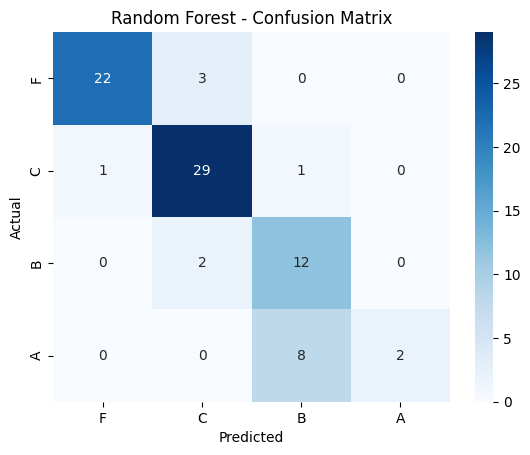

Random Forest Report:

              precision    recall  f1-score   support

           0       0.96      0.88      0.92        25
           1       0.85      0.94      0.89        31
           2       0.57      0.86      0.69        14
           3       1.00      0.20      0.33        10

    accuracy                           0.81        80
   macro avg       0.85      0.72      0.71        80
weighted avg       0.85      0.81      0.79        80



In [10]:
rf_model = RandomForestClassifier(random_state=441)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 5]
}

rf_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    scoring='accuracy',
    random_state=441
)
rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Best Parameters:\n", rf_search.best_params_, "\n")

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels = ['F', 'C', 'B', 'A'],
            yticklabels = ['F', 'C', 'B', 'A']
)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Random Forest Report:\n")
print(classification_report(y_test, y_pred_rf))



# XGBoost

Best Parameters:
 {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.8} 



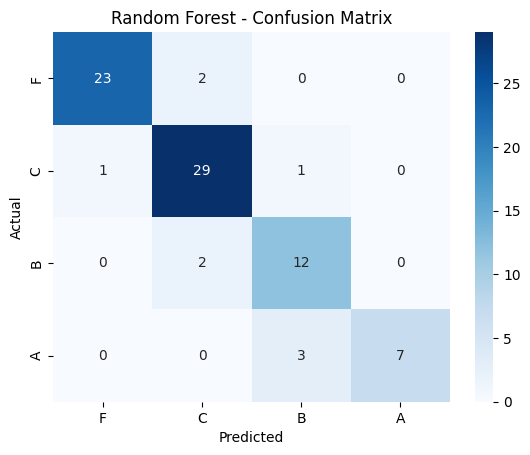

XGBoost Report:

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        25
           1       0.88      0.94      0.91        31
           2       0.75      0.86      0.80        14
           3       1.00      0.70      0.82        10

    accuracy                           0.89        80
   macro avg       0.90      0.85      0.87        80
weighted avg       0.90      0.89      0.89        80



In [11]:
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=441)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],      
    'min_child_weight': [1, 2, 4],     
    'colsample_bytree': [0.8, 1.0]  
}

grid_xgb = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy')
grid_xgb.fit(X_train, y_train)

best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("Best Parameters:\n", grid_xgb.best_params_, "\n")

cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels = ['F', 'C', 'B', 'A'],
            yticklabels = ['F', 'C', 'B', 'A']
)

plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("XGBoost Report:\n")
print(classification_report(y_test, y_pred_xgb))


# Decision Tree from Scratch

In [12]:
class DecisionTree:

    class Node:
        def __init__(self, depth = 0):
            self.feature = None
            self.children = []
            self.class_label = None
            self.is_leaf = False
            self.depth = depth
            self.majority_class = None
    
        def predict_one(self, x):
            if self.is_leaf:
                return self.class_label

            for child, value in self.children:
                if x[self.feature] == value:
                    return child.predict_one(x)
            return self.majority_class
    
    def entropy(self, y):
        counts = Counter(y)
        total = len(y)
        return -sum((count / total) * np.log2(count / total) for count in counts.values())

    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.root = self.Node()
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.X_train = X_train.reset_index(drop=True)
        self.y_train = y_train.reset_index(drop=True)

        self.features = self.X_train.columns
        indexes = list(range(len(X_train)))
        
        self._build_tree(self.root, indexes, self.features)

    def _build_tree(self, node, indexes, features):
        y_train_subset = self.y_train.iloc[indexes]

        if len(set(y_train_subset)) == 1 or len(features) == 0 or node.depth >= self.max_depth:
            node.is_leaf = True
            node.class_label = y_train_subset.mode().iloc[0]
            return

        best_feature = self._best_feature(indexes, features)
        node.feature = best_feature
        node.majority_class = y_train_subset.mode().iloc[0]

        for value in self.X_train[best_feature].unique():
            new_indexes = [i for i in indexes if self.X_train.iloc[i][best_feature] == value]
            if not new_indexes:
                continue

            child = self.Node(depth=node.depth + 1)
            node.children.append((child, value))

            self._build_tree(child, new_indexes, features.drop(best_feature))

    def _best_feature(self, indexes, features):
        base_entropy = self.entropy(self.y_train.iloc[indexes])
        best_gain = -1
        best_feature = None

        for feature in features:
            values = self.X_train.iloc[indexes][feature]
            unique_vals = values.unique()

            cond_entropy = 0
            for value in unique_vals:
                subset_idx = [i for i in indexes if self.X_train.iloc[i][feature] == value]
                subset_y = self.y_train.iloc[subset_idx]
                weight = len(subset_y) / len(indexes)
                cond_entropy += weight * self.entropy(subset_y)

            info_gain = base_entropy - cond_entropy
            if info_gain > best_gain:
                best_gain = info_gain
                best_feature = feature

        return best_feature

    def predict(self, X_train):
        return [self.root.predict_one(row) for _ , row in X_train.iterrows()]
    
    def visualize(self, filename="tree", width=8, height=6, dpi=100):
        dot = Digraph()
        dot.attr(size=f"{width},{height}")
        dot.attr(dpi=str(dpi))
        dot.attr(ranksep='4,3', nodesep='0.3') 
        
        counter = [0]

        def add_node(node):
            node_id = str(counter[0])
            counter[0] += 1

            if node.is_leaf:
                label = f"Label: {node.class_label}"
                dot.node(node_id, label, shape="box", style="filled", fillcolor="lightgreen")
            else:
                label = f"{node.feature}\nMajority: {node.majority_class}"
                dot.node(node_id, label, shape="ellipse", style="filled", fillcolor="lightblue")

            for child, val in node.children:
                child_id = add_node(child)
                edge_label = f"{val:.2f}" if isinstance(val, float) else str(val)
                dot.edge(node_id, child_id, label=edge_label)

            return node_id

        add_node(self.root)
        dot.render(filename, format='png', cleanup=True)
        display(Image(filename + '.png'))
        
    def feature_importances(self):
        importances = {}

        def traverse(node, total_samples):
            if node.is_leaf:
                return 0

            base_entropy = self.entropy(self.y_train)
            gain = base_entropy

            for child, val in node.children:
                child_indexes = self.X_train[self.X_train[node.feature] == val].index
                child_y = self.y_train.loc[child_indexes]
                weight = len(child_y) / total_samples
                gain -= weight * self.entropy(child_y)

            importances[node.feature] = importances.get(node.feature, 0) + gain

            for child, val in node.children:
                traverse(child, total_samples)

        traverse(self.root, len(self.X_train))

        total = sum(importances.values())
        for key in importances:
            importances[key] /= total
        
        importances_list = pd.Series(importances).sort_values()
        
        threshold = 0.025
        importances_filtered = importances_list.copy()
        low_importance = importances_filtered[importances_filtered < threshold]
        other_total = low_importance.sum()

        importances_filtered = importances_filtered[importances_filtered >= threshold]

        if other_total > 0:
            importances_filtered['Other'] = other_total
        
        return importances_filtered


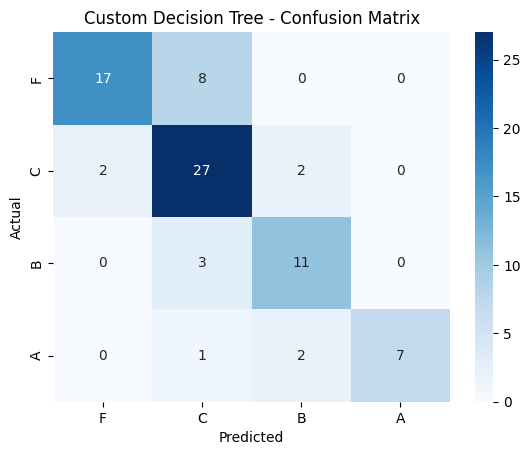

              precision    recall  f1-score   support

           0       0.89      0.68      0.77        25
           1       0.69      0.87      0.77        31
           2       0.73      0.79      0.76        14
           3       1.00      0.70      0.82        10

    accuracy                           0.78        80
   macro avg       0.83      0.76      0.78        80
weighted avg       0.80      0.78      0.78        80



In [13]:

dt_scratch_model = DecisionTree(max_depth=5)
dt_scratch_model.fit(X_train, y_train)
y_pred_dt_scratch = dt_scratch_model.predict(X_test)


# colors = ['#FFD700','#40E0D0','#FF9999','#66B3FF','#99FF99','#DA70D6','#FFCC99','#C2C2F0','#FFB6C1','#F0E68C',
#           '#FA8072','#87CEFA','#FF6347','#BA55D3','#7FFFD4','#90EE90','#FFA07A']
# importances = dt_scratch_model.feature_importances()
# plt.figure(figsize=(10, 10))
# colors_filtered = colors[:len(importances)]
# importances.plot(kind='pie', colors=colors_filtered)
# plt.title("Feature Importances (with 'Other')")
# plt.ylabel('')
# plt.tight_layout()
# plt.show()

cm = confusion_matrix(y_test, y_pred_dt_scratch)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['F', 'C', 'B', 'A'],
            yticklabels=['F', 'C', 'B', 'A'])
plt.title("Custom Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred_dt_scratch))
dt_scratch_model.visualize(filename="Decision Tree Scratch", width=70, height=100, dpi=200)

In [14]:
models = ['Naive Bayes Gaussian','Naive Bayes Categorical', 'Decision Tree','Decision Tree Limit', 'Random Forest', 'XGBoost', 'Decision Tree Scratch']
accuracies = [
    accuracy_score(y_test, y_pred_nb_gaussian),
    accuracy_score(y_test, y_pred_nb_categorical),
    accuracy_score(y_test, y_pred_dt),
    accuracy_score(y_test, y_pred_dt_limit),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_dt_scratch)
]

comparison_data_file = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies
})

comparison_data_file.sort_values(by='Accuracy', ascending=False)


Model  Accuracy
5                  XGBoost    0.8875
4            Random Forest    0.8125
1  Naive Bayes Categorical    0.8125
3      Decision Tree Limit    0.7750
6    Decision Tree Scratch    0.7750
2            Decision Tree    0.7500
0     Naive Bayes Gaussian    0.6750

# Predicrtor

In [15]:
sample_data = {
    'reason': ['course'],
    'address': ['U'],
    'studyTime': [4],
    'universitySupport' : ['no'],
    'failures': [0],
    'higher': ['yes'],
    'paid': ['no'],
    'romantic': ['yes'],
    'freeTime': [2],
    'goOut': [2],
    'Dalc': [1],
    'Walc': [1],
    'travelTime': [2],
    'motherEducation': [4],
    'fatherEducation': [4],
    'internet': ['yes'],
    'absencesEncoded': ['C'],
    'EPSGradeEncoded': ['A'],
    'DSGradeEncoded': ['A']
}

sample_df = pd.DataFrame(sample_data)

sample_df = pd.DataFrame(sample_data)

for col, le in label_encoders.items():
    if col in sample_df.columns:
        sample_df[col] = le.transform(sample_df[col])

sample_df = sample_df.reindex(columns=X_train.columns)
print("Prediction (Naive Bayes Gaussian):", nb_gaussian_model.predict(sample_df))
print("Prediction (Naive Bayes Categorical):", nb_categorical_model.predict(sample_df))
print("Prediction (Decision Tree):", dt_model.predict(sample_df))
print("Prediction (Decision Tree Limited):", dt_limit_model.predict(sample_df))
print("Prediction (Random Forest):", rf_model.predict(sample_df))
print("Prediction (XGBoost):", xgb_model.predict(sample_df))
print("Prediction (Custom DT):", dt_scratch_model.predict(sample_df))


ValueError: could not convert string to float: 'A'